# DOS purpose:
Group A: (customer segmentation – RFM & hierarchical clustering)
1.	Develop customer segmentation based on RFM + Hierarchical clustering 
2.	Calculate Recency, Frequency, and Monetary metrics at the customer level 
3.	Run hierarchical clustering on your data and decide where you’d like to cut your dendrogram (i.e. how many clusters/segments do you want) 
4.	Conduct exploratory analysis to see if you can find any meaningful differences amongst customers in terms of the most/least popular products purchased within each cluster, number of refunds, day of week, etc. 
5.	Interpret your outputs, describe each segment in terms of value, hypothesize what type of customers might make up the majority of each segment, and brainstorm marketing strategies for each segment – subgroup 1



# Load packages

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
import itertools
import scipy
import pandas_profiling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load data

In [3]:
df=pd.read_excel('/System/Volumes/Data/Users/Michael/Library/CloudStorage/iCloud Drive/MMA/MMA 831/Dos2/Online Retail.xlsx')

# check the data

In [4]:
df.head(20)
df.info()
df.describe()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Clean data

There is nagive number in both quantity and Unitprice. So, we dropped these instances.
Besides, our analysis is based on CustomerID. So we drop the instances that are missing value.

In [5]:
df_drop_nagtive=df[(df.Quantity>0)&(df.UnitPrice)>0]
df_drop_missing_value=df_drop_nagtive[pd.notnull(df_drop_nagtive['CustomerID'])]
df_drop_missing_value.info()
df_drop_missing_value.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      397884 non-null object
StockCode      397884 non-null object
Description    397884 non-null object
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null float64
Country        397884 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


Check the latest date and set the baseline

In [6]:
df_drop_missing_value['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [7]:
Day_baseline=df_drop_missing_value['InvoiceDate'].max()+dt.timedelta(days=1)
Day_baseline

Timestamp('2011-12-10 12:50:00')

Caculate the total price for each instance

In [8]:
df_drop_missing_value['Total_Price']=df_drop_missing_value.Quantity*df_drop_missing_value.UnitPrice

/Users/Michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_cleaned=df_drop_missing_value
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Create RFM table

In [10]:
rfmTable = df_cleaned.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Day_baseline - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Total_Price': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Total_Price': 'monetary_value'}, inplace=True)
rfmTable.head()
rfmTable.info()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
recency           4338 non-null int64
frequency         4338 non-null int64
monetary_value    4338 non-null float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


In [11]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [12]:
quantiles

{'recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.0},
 'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 100.0},
 'monetary_value': {0.25: 307.41499999999996,
  0.5: 674.4849999999999,
  0.75: 1661.7400000000002}}

In [13]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [14]:
segmented_rfm = rfmTable.copy()
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,326,1,77183.60,4,4,1
12347.0,2,182,4310.00,1,1,1
12348.0,75,31,1797.24,3,3,1
12349.0,19,73,1757.55,2,2,1
12350.0,310,17,334.40,4,4,3


# Clustering

# Normalize the Data

In [15]:
X = rfmTable.copy()
X.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [16]:
#X.monetary_value=np.log(X.monetary_value)
scaler = StandardScaler()
features = ['recency','frequency','monetary_value']
X[features] = scaler.fit_transform(X[features])
X.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,2.334574,-0.396578,8.358668
12347.0,-0.905340,0.394649,0.250966
12348.0,-0.175360,-0.265435,-0.028596
12349.0,-0.735345,-0.081836,-0.033012
12350.0,2.174578,-0.326635,-0.191347


In [17]:
#pandas_profiling.ProfileReport(X, check_correlation = False)

# Elbow Method to find the best cluster number

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

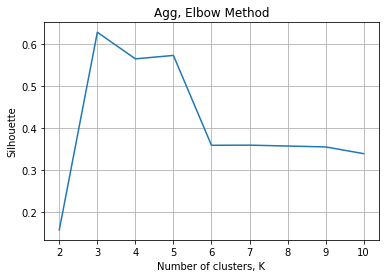

In [18]:
silhouettes = {}
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(X)
    silhouettes[k] = silhouette_score(X, agg.labels_, metric='cosine')
    
    
    plt.figure();
plt.grid(True);
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('Agg, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

3 is the best cluster number

In [19]:
agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agg.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3,
                        pooling_func='deprecated')

In [20]:
silhouette_score(X, agg.labels_)

0.5269205165271833

# find the best linkage and metrics

Linkage=complete, Metric=euclidean, Clusters=3, Silhouette=0.93
Linkage=complete, Metric=minkowski, Clusters=3, Silhouette=0.93
Linkage=complete, Metric=cityblock, Clusters=3, Silhouette=0.925
Linkage=complete, Metric=cosine, Clusters=3, Silhouette=0.707
Linkage=complete, Metric=correlation, Clusters=3, Silhouette=0.85
Linkage=complete, Metric=chebyshev, Clusters=3, Silhouette=0.946
Linkage=complete, Metric=mahalanobis, Clusters=3, Silhouette=0.946
Linkage=single, Metric=euclidean, Clusters=3, Silhouette=0.949
Linkage=single, Metric=minkowski, Clusters=3, Silhouette=0.949
Linkage=single, Metric=cityblock, Clusters=3, Silhouette=0.952
Linkage=single, Metric=cosine, Clusters=3, Silhouette=-0.132
Linkage=single, Metric=correlation, Clusters=3, Silhouette=-0.101
Linkage=single, Metric=chebyshev, Clusters=3, Silhouette=0.943
Linkage=single, Metric=mahalanobis, Clusters=3, Silhouette=0.943
Linkage=centroid, Metric=euclidean, Clusters=3, Silhouette=0.93
Linkage=average, Metric=euclidean, Clus

/Users/Michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Linkage=average, Metric=mahalanobis, Clusters=3, Silhouette=0.946


/Users/Michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


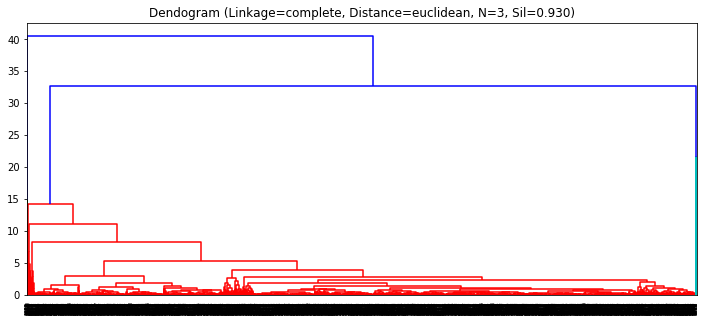

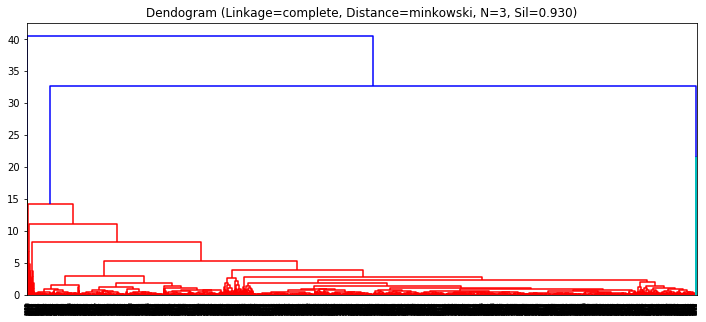

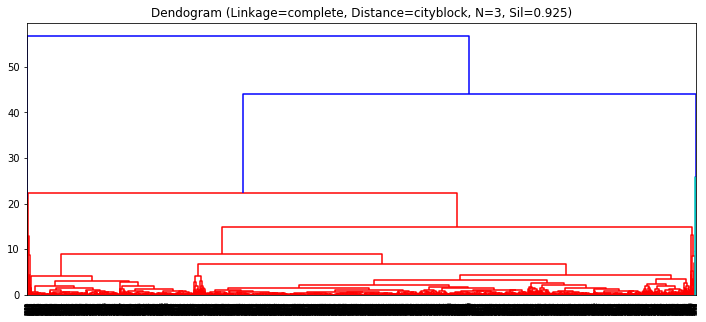

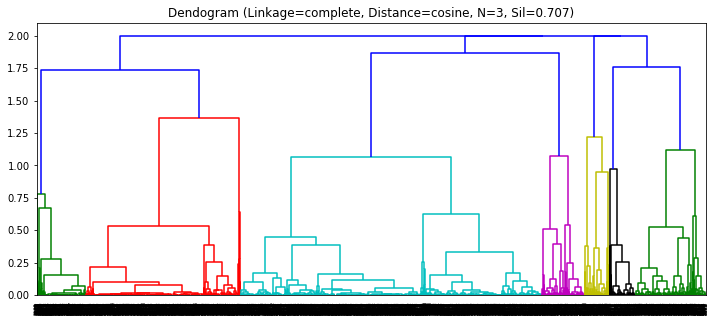

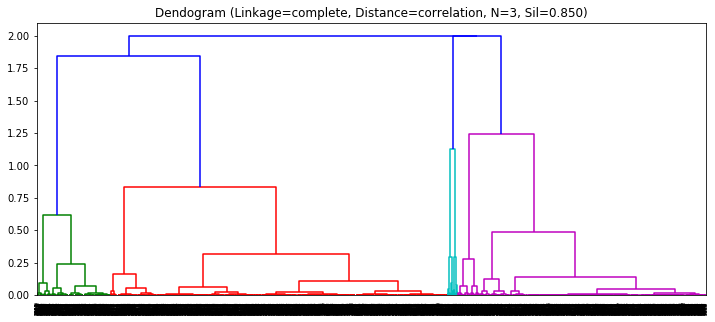

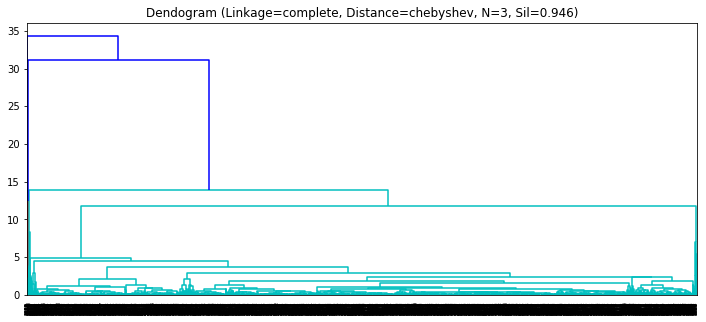

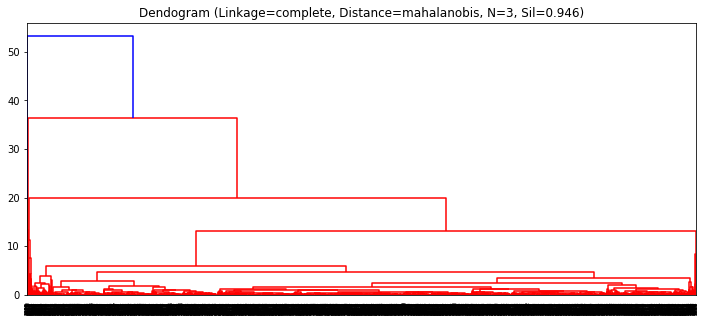

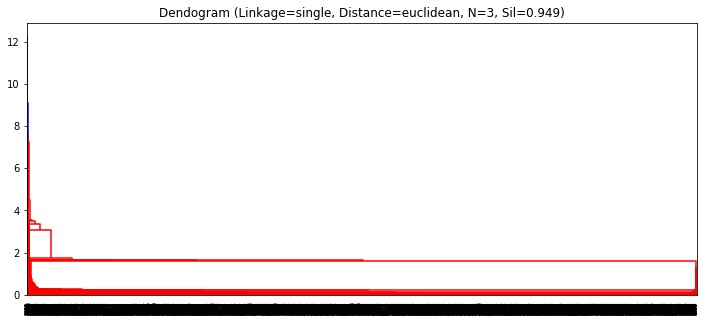

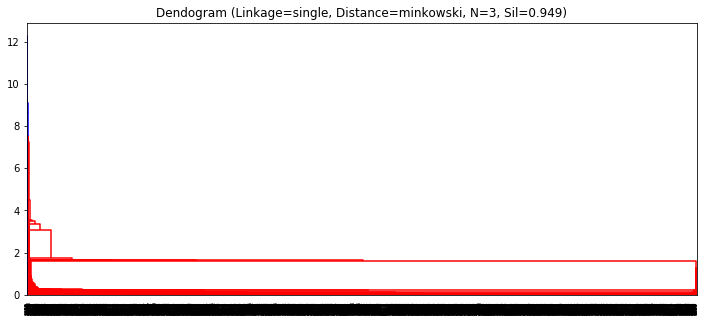

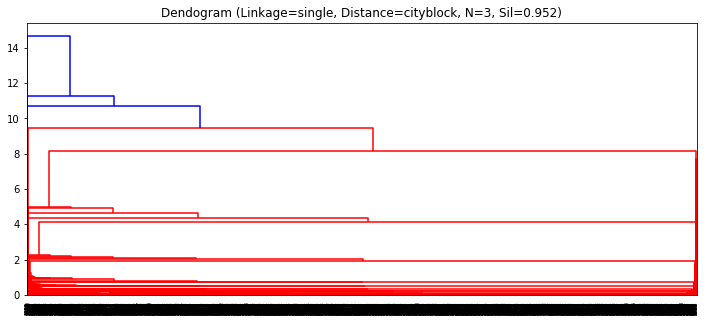

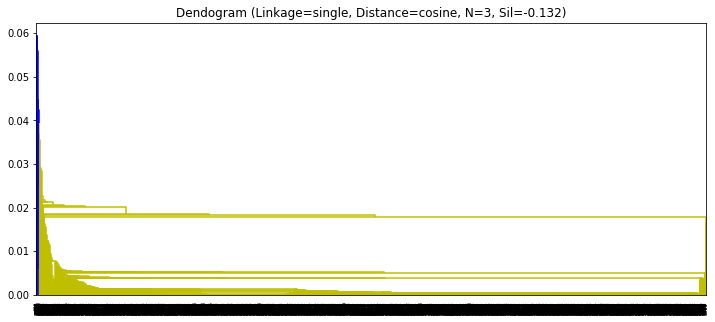

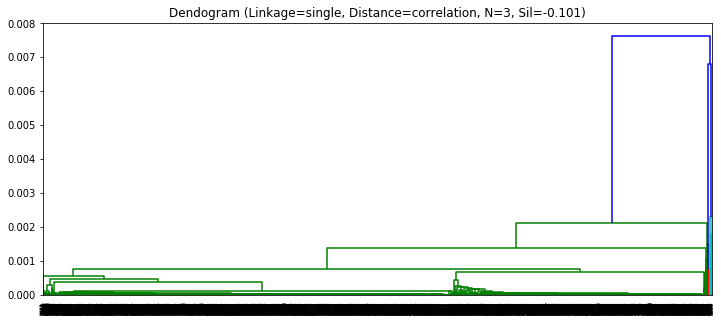

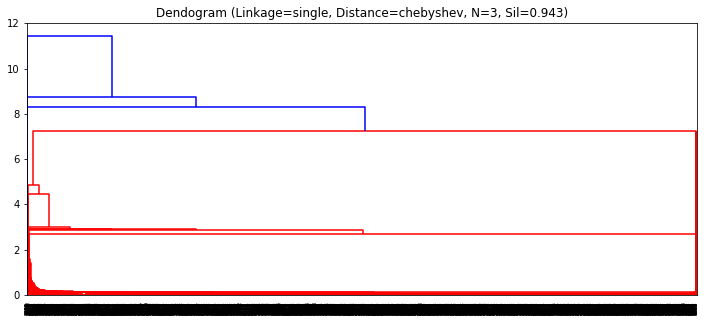

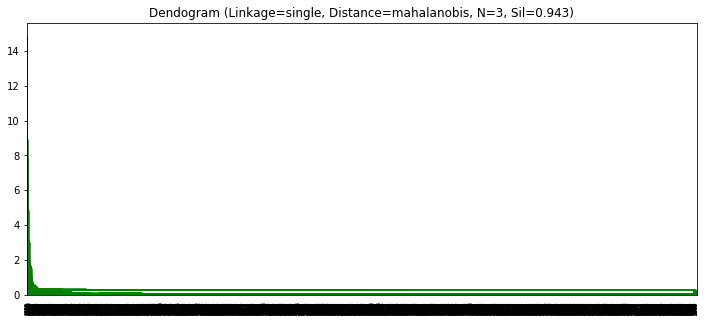

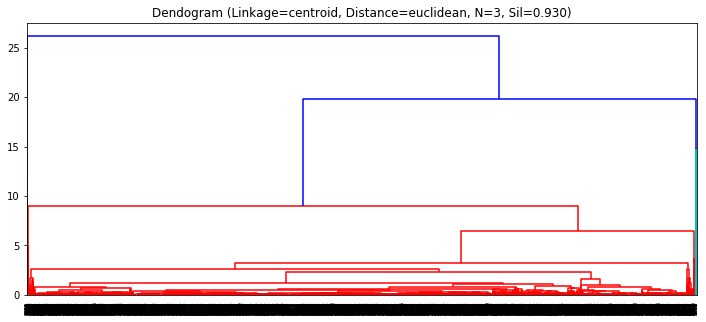

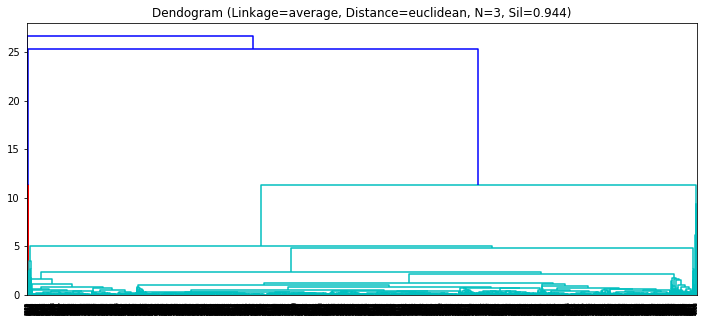

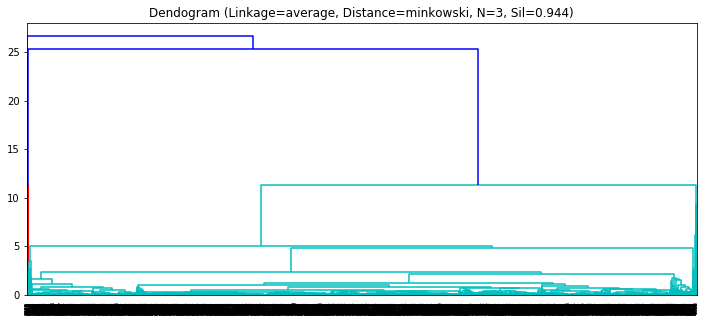

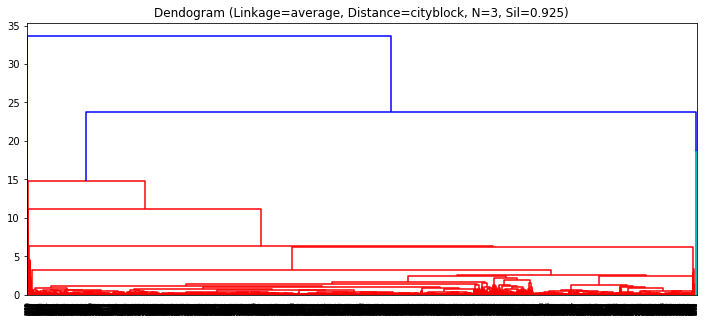

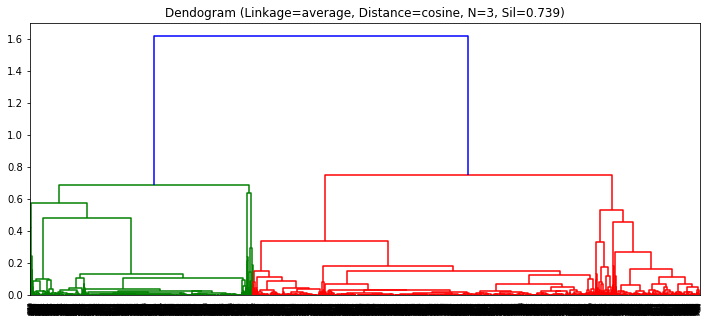

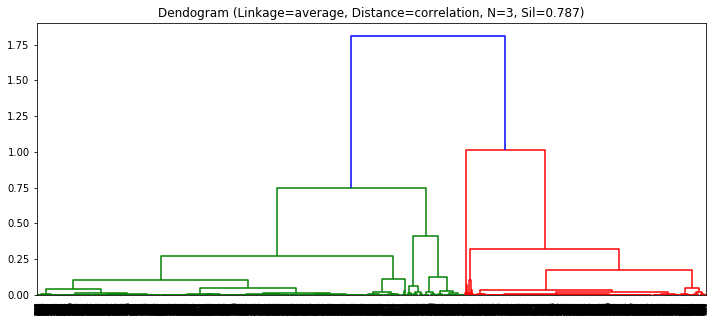

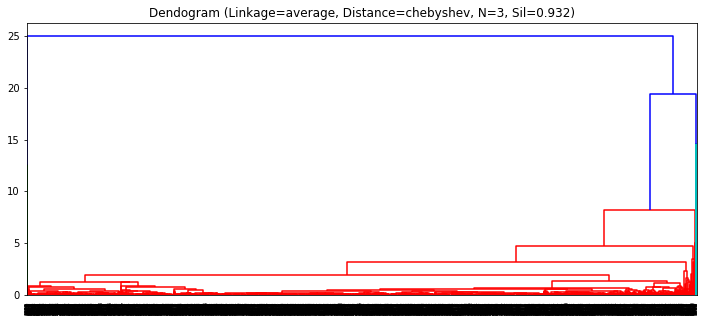

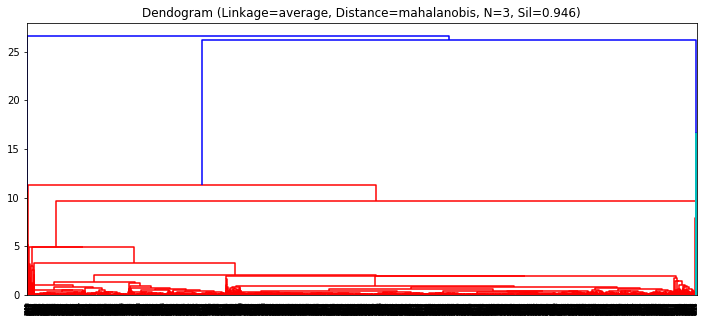

In [20]:
def plot_agg(X, linkage, metric):
    aggl = scipy.cluster.hierarchy.linkage(X, method=linkage, metric=metric)
    
    labels = scipy.cluster.hierarchy.fcluster(aggl, 3, criterion="maxclust")
    
    sil = 0
    n = len(set(labels))
    if n > 1:
        sil = silhouette_score(X , labels, metric=metric)
    print("Linkage={}, Metric={}, Clusters={}, Silhouette={:.3}".format(linkage, metric, n, sil))
    
    # Plot the dendogram
    plt.figure(figsize=(12, 5))  
    plt.title("Dendogram (Linkage={}, Distance={}, N={}, Sil={:.3f})".format(linkage, metric, n, sil))  
    dend = scipy.cluster.hierarchy.dendrogram(aggl) 
    
linkages = ['complete', 'single', 'centroid', 'average']
metrics = ['euclidean', 'minkowski', 'cityblock', 'cosine', 'correlation', 'chebyshev', 'mahalanobis']

for prod in list(itertools.product(linkages, metrics)):
    
    # Some combos are not allowed
    if (prod[0] in [ 'centroid']) and prod[1] != 'euclidean':
        continue
        
    plot_agg(X, prod[0], prod[1])

In [21]:
agg = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
agg.fit(X)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3,
                        pooling_func='deprecated')

In [27]:
agg.labels_
len(agg.labels_)
len(X)

array([0, 0, 2, ..., 2, 0, 2])

4338

4338

In [23]:
X['label']=agg.labels_
rfmTable['label']=agg.labels_

In [24]:
rfmTable.loc[rfmTable['label']==0].describe()

,recency,frequency,monetary_value,label
count,788.000000,788.000000,788.000000,788.0
mean,25.850254,308.436548,7929.100063,0.0
std,29.167708,473.245234,20017.722830,0.0
min,1.000000,1.000000,532.960000,0.0
25%,5.000000,154.000000,2607.340000,0.0
50%,16.000000,216.000000,3774.170000,0.0
75%,35.250000,329.250000,6210.242500,0.0
max,326.000000,7847.000000,280206.020000,0.0


In [25]:
rfmTable.loc[rfmTable['label']==1].describe()

,recency,frequency,monetary_value,label
count,1320.000000,1320.000000,1320.000000,1320.0
mean,224.425758,31.739394,576.569236,1.0
std,77.410961,35.870548,770.469744,0.0
min,96.000000,1.000000,3.750000,1.0
25%,158.000000,10.000000,183.550000,1.0
50%,217.000000,20.000000,335.125000,1.0
75%,283.000000,40.000000,632.302500,1.0
max,374.000000,327.000000,9864.260000,1.0


In [26]:
rfmTable.loc[rfmTable['label']==2].describe()

,recency,frequency,monetary_value,label
count,2230.000000,2230.000000,2230.000000,2230.0
mean,38.031839,50.645740,853.007024,2.0
std,27.766578,39.823704,675.987465,0.0
min,1.000000,1.000000,6.200000,2.0
25%,15.000000,19.000000,328.612500,2.0
50%,31.000000,40.000000,656.960000,2.0
75%,59.000000,73.750000,1215.545000,2.0
max,113.000000,201.000000,3861.000000,2.0
